# ¿Qué variables destacadas influyen en el precio de las viviendas?

In [1]:
# Load packages
from IPython.display import Image
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, ElasticNet



# This line is needed to display plots inline in Jupyter Notebook
%matplotlib inline


import warnings
warnings.filterwarnings('ignore')

## Objetivo

En ciencia de datos y aprendizaje automático, uno de los mayores retos es crear modelos que funcionen bien con datos no utilizados en el entrenamiento. El equilibrio en la complejidad del modelo es clave: los modelos muy complejos pueden sobreajustarse, mientras que los demasiado simples pueden subajustarse. Para abordar estos problemas, se emplea la regularización, una técnica que ajusta la complejidad del modelo penalizando coeficientes grandes. Este documento se centra en la regularización en la regresión lineal, específicamente en Ridge (L2) y Lasso (L1), técnicas que mejoran la generalización y robustez de los modelos.

### Problema a Solucionar

En el negocio inmobiliario, la precisión en la predicción de precios es fundamental para tomar decisiones de inversión acertadas. En este caso, se dispone de un conjunto de datos de viviendas y se busca responder a la pregunta: **"¿Qué variables son las más importantes para predecir los precios de las viviendas?"**. El proceso para abordar este problema incluye los siguientes pasos:

1. **Exploración de Datos** para identificar las características más relevantes.
2. Aplicación de **Regularización L1 (LASSO)** para eliminar variables menos importantes y reducir el número de características del modelo.
3. Uso de **Regularización L2 (Ridge)** para controlar la multicolinealidad y estabilizar los coeficientes.
4. Implementación de **Elastic Net**, que combina L1 y L2, para obtener un modelo equilibrado y robusto que haga predicciones precisas y generalizables.

Este enfoque garantiza la construcción de un modelo optimizado y eficiente para predecir de manera precisa los precios de las viviendas.

### Introducción a los datos de precios de viviendas de Saratoga

Carguemos los datos en un DataFrame de `pandas`. Hay quince características que pueden utilizarse para predecir el ```precio``` de una vivienda:

**Cantidad de interés:**
1. **price**: precio en millones de dólares estadounidenses

**Características numéricas no categóricas:**
1. **lotSize**: tamaño del lote en acres
2. **age**: antigüedad de la casa en años
3. **landValue**: valor del terreno en dólares estadounidenses
4. **livingArea**: área habitable en pies cuadrados
5. **pctCollege**: porcentaje del vecindario que se graduó de la universidad

**Características numéricas categóricas:**
1. **bedrooms**: número de dormitorios
2. **fireplaces**: número de chimeneas
3. **bathrooms**: número de baños
4. **rooms**: número de habitaciones

**Características categóricas no numéricas:**
1. **heating**: tipo de calefacción que utiliza la casa
2. **fuel**: tipo de combustible que utiliza la casa
3. **sewer**: tipo de sistema de alcantarillado que tiene la casa
4. **waterfront**: si la casa tiene o no frente al agua
5. **newConstruction**: si la casa es de nueva construcción o no
6. **centralAir**: si la casa tiene o no sistema de aire acondicionado central

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Load and preview data
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks//saratoga-Casas_limpio.csv')
df.head()

,price,lotSize,age,landValue,livingArea,pctCollege,bedrooms,fireplaces,bathrooms,rooms,heating,fuel,sewer,waterfront,newConstruction,centralAir
0,0.132500,0.09,42,50000,906,35,2,1,1.0,5,electric,electric,septic,No,No,No
1,0.181115,0.92,0,22300,1953,51,3,0,2.5,6,hot water/steam,gas,septic,No,No,No
2,0.109000,0.19,133,7300,1944,51,4,1,1.0,8,hot water/steam,gas,public/commercial,No,No,No
3,0.155000,0.41,13,18700,1944,51,3,1,1.5,5,hot air,gas,septic,No,No,No
4,0.086060,0.11,0,15000,840,51,2,0,1.0,3,hot air,gas,public/commercial,No,Yes,Yes


## Exploración de las relaciones entre características mediante la visualización de datos

Comencemos visualizando la relación entre las variables y los precios de las viviendas mediante un mapa de calor o diagramas de dispersión 2D, empezando por las características numéricas no categóricas:

In [5]:
df.dtypes

,0
price,float64
lotSize,float64
age,int64
landValue,int64
livingArea,int64
pctCollege,int64
bedrooms,int64
fireplaces,int64
bathrooms,float64
rooms,int64


<Figure size 2400x2000 with 0 Axes>

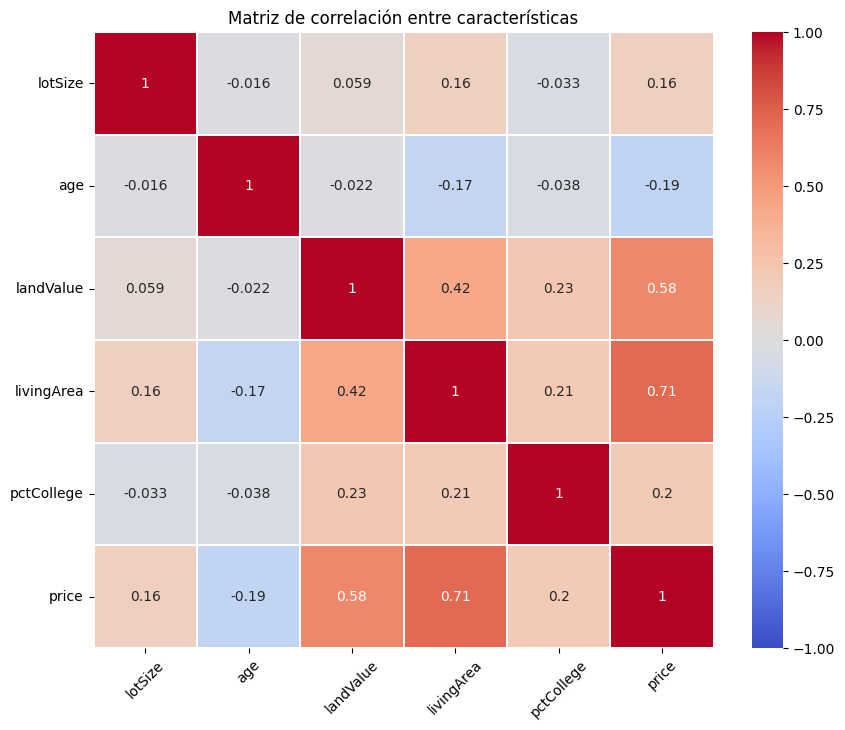

In [6]:
# Numeric non-catgorical features
plt.figure(figsize=(24,20))
varstolook = ['lotSize', 'age', 'landValue', 'livingArea', 'pctCollege','price']
# Calcular la matriz de correlación
correlation_matrix = df[varstolook].corr()

# Configurar el tamaño del gráfico
plt.figure(figsize=(10, 8))

# Crear el heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.3, vmin=-1, vmax=1)

# Añadir título al gráfico
plt.title('Matriz de correlación entre características')

# Ajustar las etiquetas de los ejes si es necesario
plt.xticks(rotation=45)
plt.yticks(rotation=0)

# Mostrar el gráfico
plt.show()

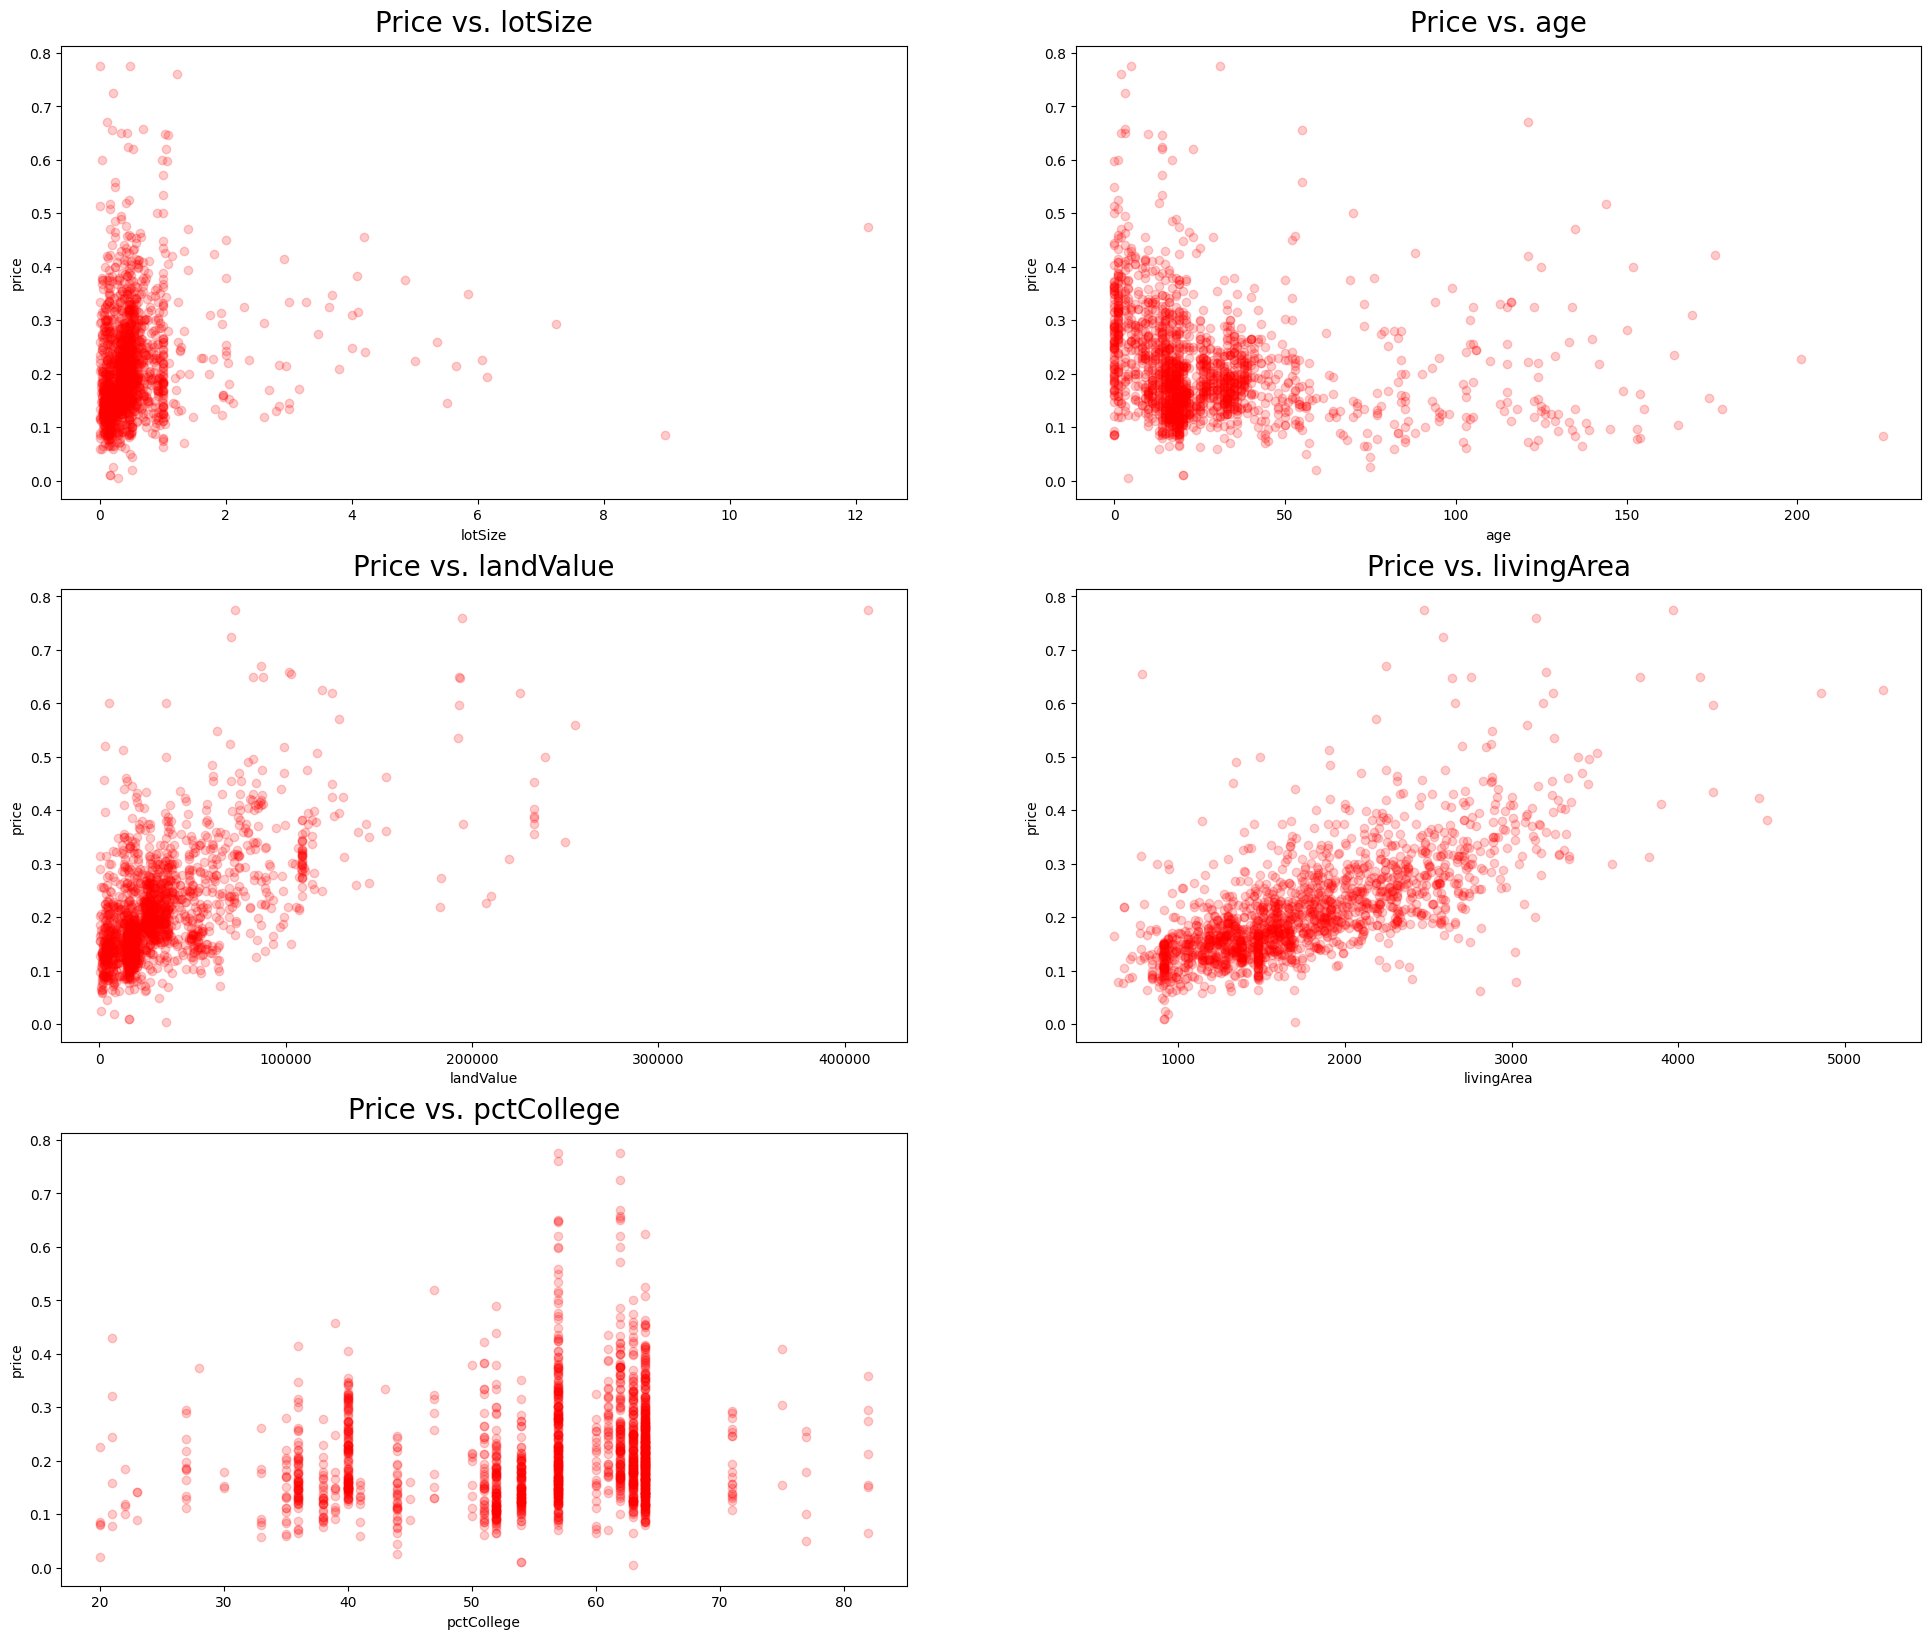

In [7]:
# Numeric non-catgorical features
plt.figure(figsize=(24,20))
varstolook = ['lotSize', 'age', 'landValue', 'livingArea', 'pctCollege']
for i,feature in enumerate(varstolook):
    plt.subplot(3,2,i+1)
    colvalues = df[feature]
    plt.scatter(colvalues.values, df.price.values, alpha=0.20, edgecolor=None, color='red')
    plt.xlabel(feature)
    plt.ylabel('price')
    plt.title("Price vs. " + feature, fontsize=20, verticalalignment='bottom');

### Algunas observaciones son evidentes:

Primero, las variables ```livingArea```y ```landValue```  están positivamente correlacionadas con los precios de las viviendas. A continuación, la antigüedad de una vivienda está inversamente correlacionada con el precio hasta aproximadamente los 50 años, momento en el que la relación precio-edad se vuelve plana. Curiosamente, la variable ```pctCollege``` muestra agrupaciones alrededor de ciertos porcentajes; sin embargo, no parece haber una relación fuerte entre el precio y ```pctCollege```.

Vamos a observar las características numéricas categóricas para ver si podemos identificar algún patrón significativo:

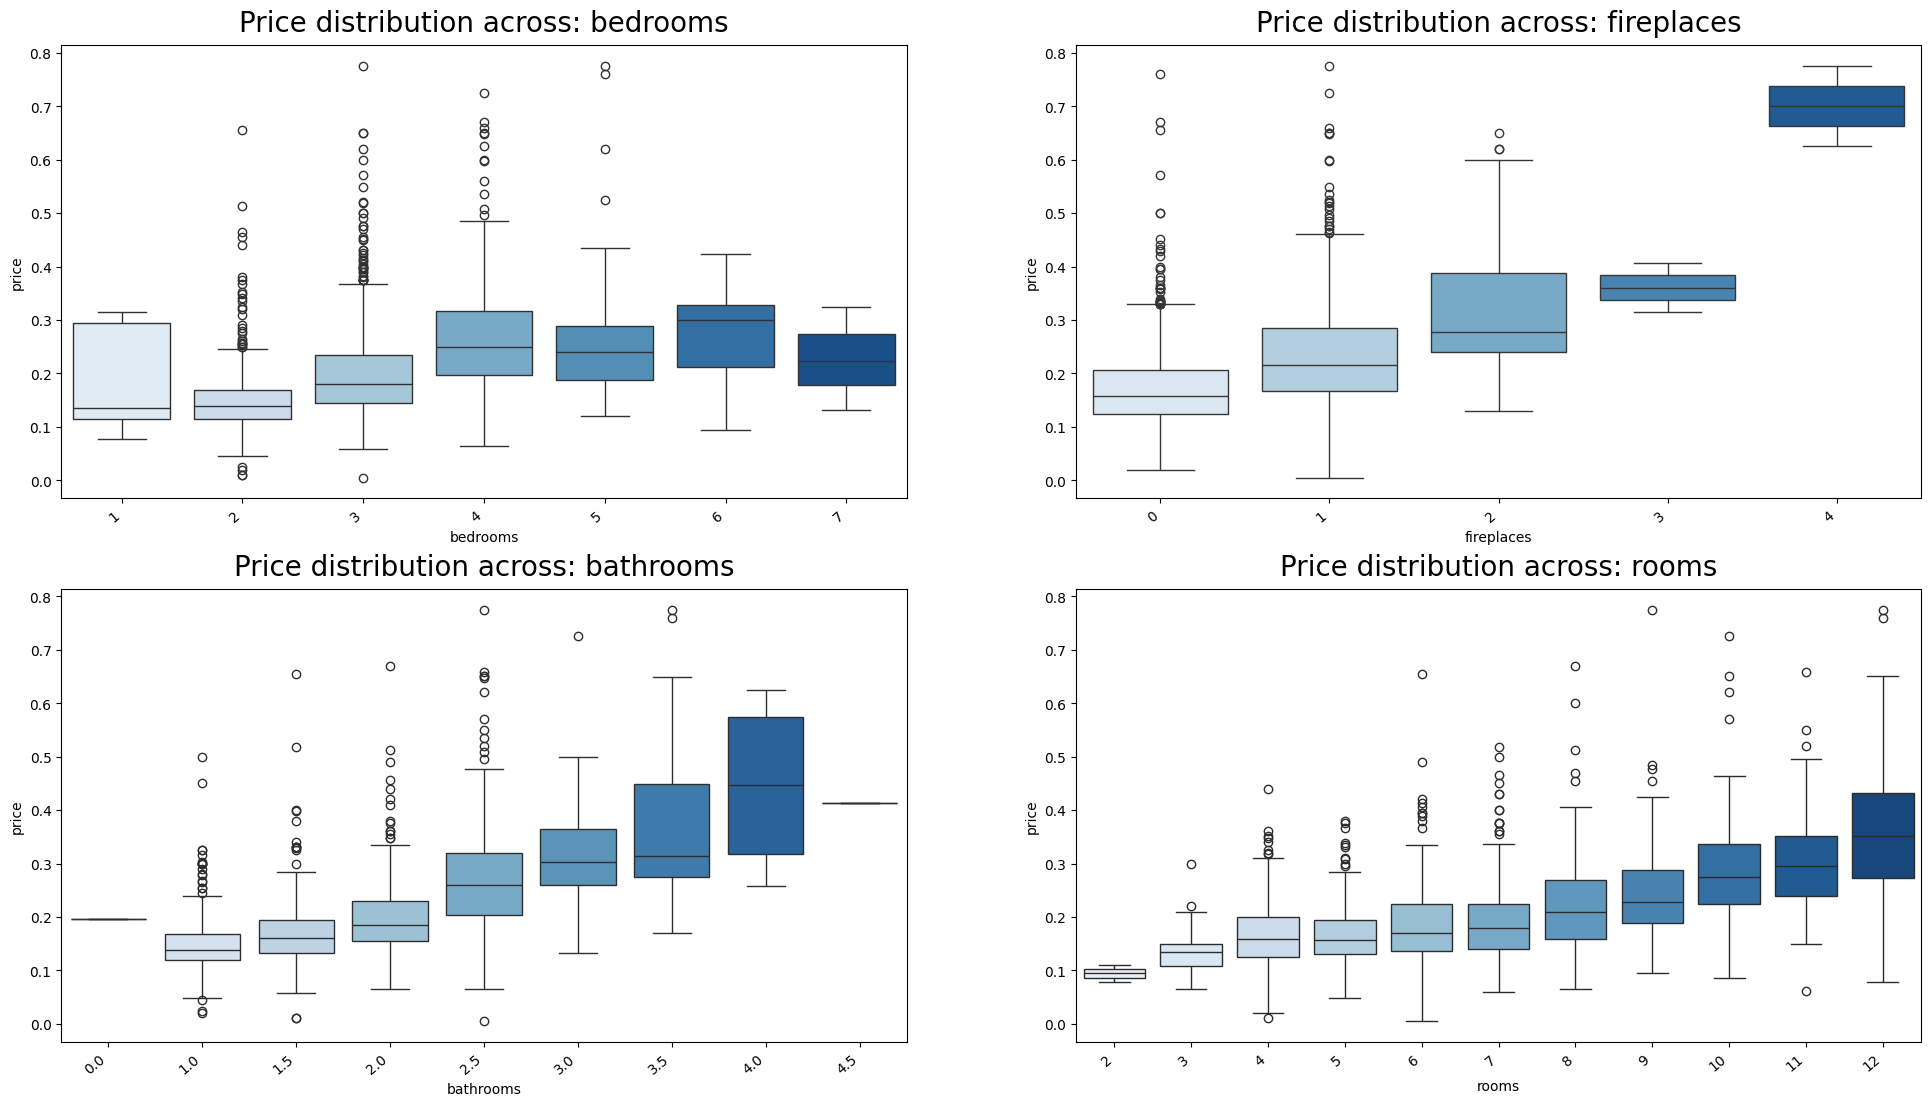

In [8]:
# Numeric categorical features
plt.figure(figsize=(24,20))
varstolook = ['bedrooms', 'fireplaces', 'bathrooms', 'rooms']
for i,feature in enumerate(varstolook):
    plt.subplot(3,2,i+1)
    pl2 = sns.boxplot(x=feature, y = "price", data = df, palette="Blues")
    pl2.set_xticklabels(pl2.get_xticklabels(), rotation=40, ha="right");
    plt.title("Price distribution across: " + feature, fontsize=20, verticalalignment='bottom');

Inmediatamente notamos la fuerte relación que las variables ```rooms```, ```bathrooms``` y ```fireplaces``` tienen con los precios de las viviendas. Esto es esperado, ya que las casas más grandes naturalmente tienen más habitaciones y exigen un precio de venta más alto. En cuanto a la variable ```bedrooms```, la tendencia de aumento de precios también está presente a medida que aumenta el número de dormitorios, pero es más débil cuando hay un número bajo (1) o alto (7) de dormitorios.

### Ejercicio:

Crea diagramas de caja (boxplots) para visualizar cada característica categórica no numérica en relación con los precios para cada valor de categoría dentro de esas características categóricas. Deberías tener seis gráficos con diagramas de caja para cada valor de categoría, uno para cada característica categórica no numérica:

1. `heating`
2. `fuel`
3. `sewer`
4. `waterfront`
5. `newConstruction`
6. `centralAir`

**Respuesta.**

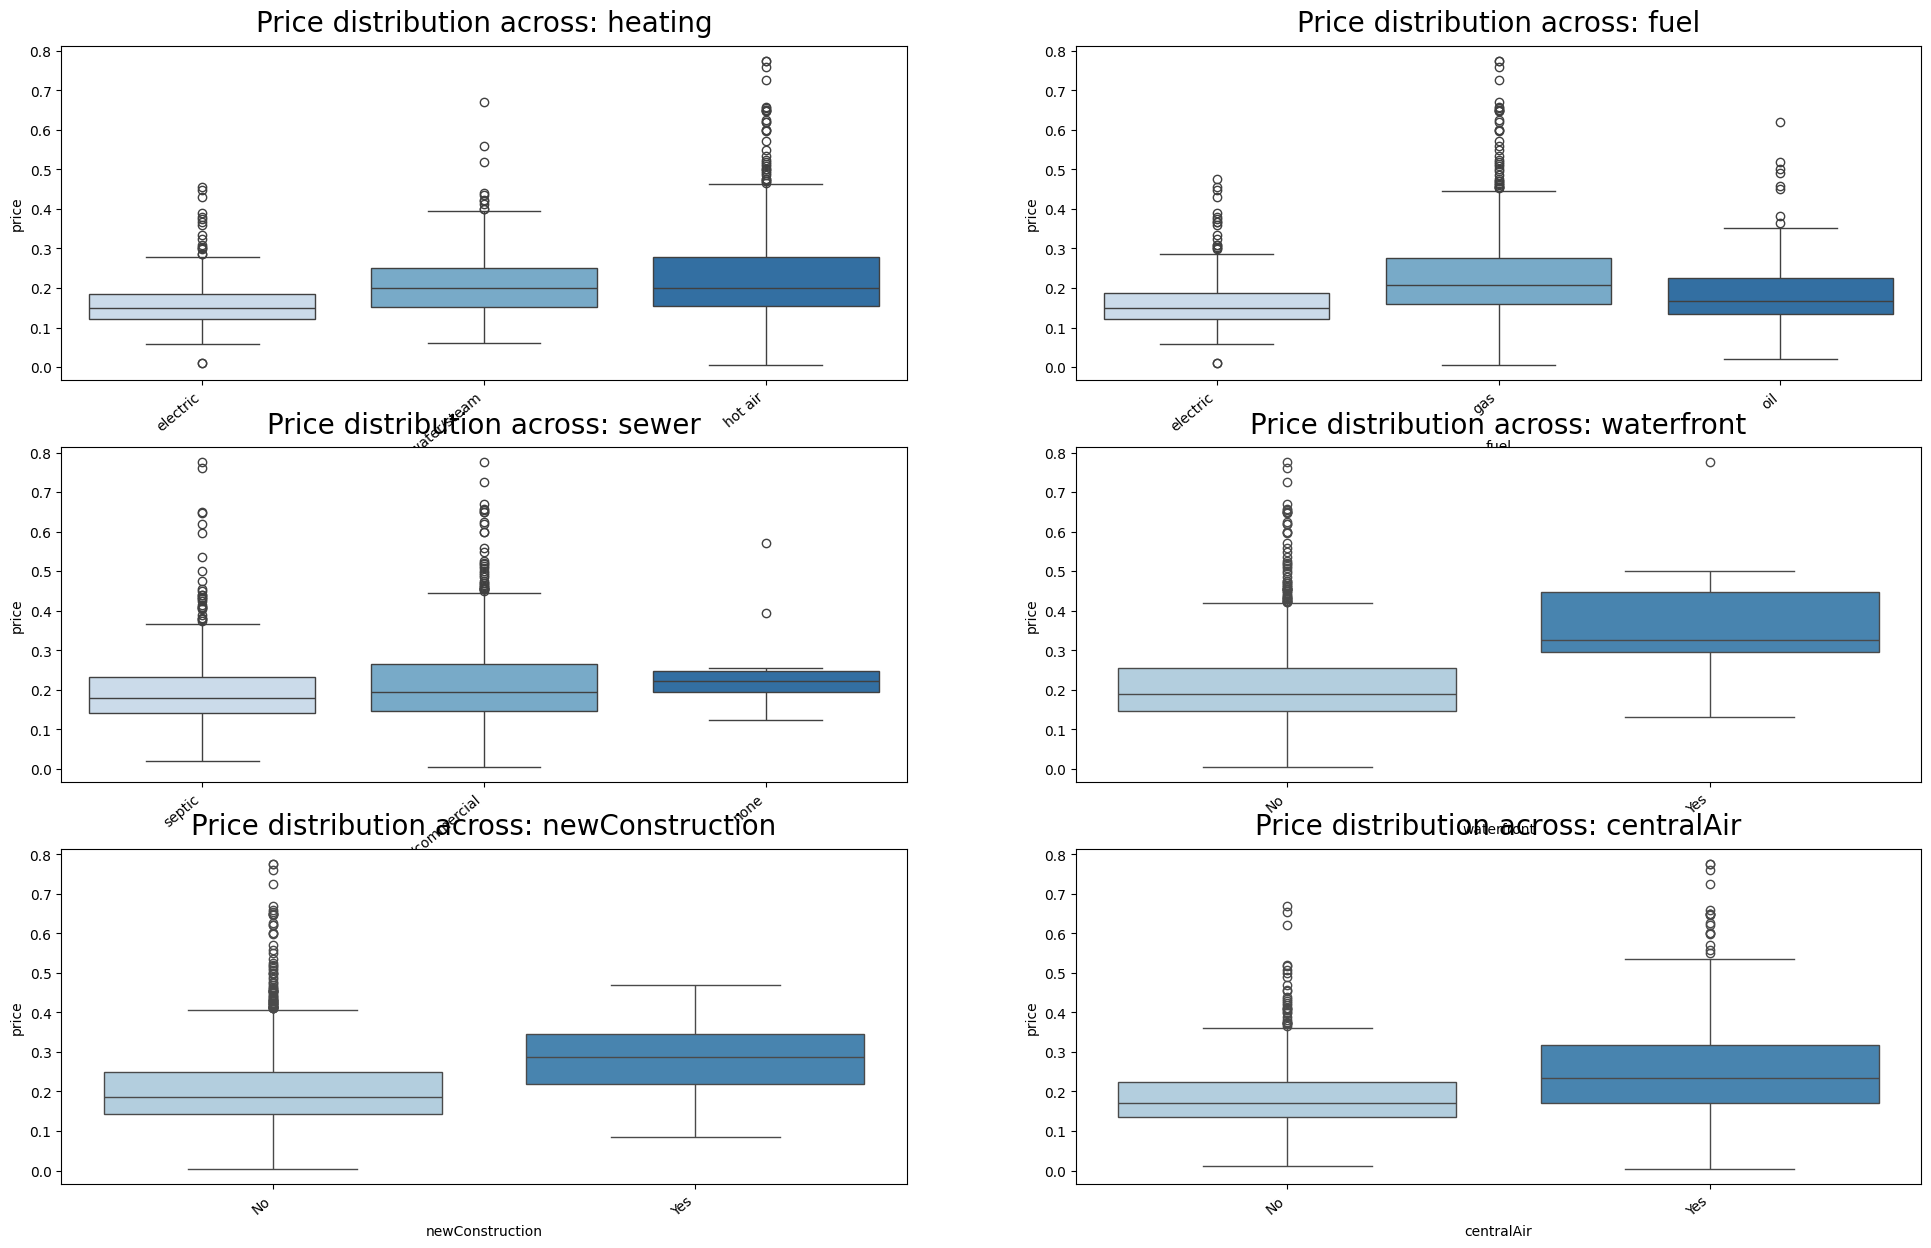

In [9]:
# Numeric categorical features
plt.figure(figsize=(24,20))
varstolook = ['heating', 'fuel', 'sewer', 'waterfront', 'newConstruction', 'centralAir']
for i,feature in enumerate(varstolook):
    plt.subplot(4,2,i+1)
    pl2 = sns.boxplot(x=feature, y = "price", data = df, palette="Blues")
    pl2.set_xticklabels(pl2.get_xticklabels(), rotation=40, ha="right");
    plt.title("Price distribution across: " + feature, fontsize=20, verticalalignment='bottom');

Como era de esperar, las propiedades frente al agua, las unidades de nueva construcción y las casas con aire acondicionado central se asocian con precios más altos. Aunque en menor medida, también se observan diferencias en las variables relacionadas con la calefacción, el tipo de combustible y el sistema de alcantarillado. Las viviendas con calefacción por aire caliente, combustible de gas y sistemas de alcantarillado público o comercial tienden a tener precios más elevados en comparación con otras opciones categóricas.

### Preparando los datos

Antes de comenzar a modelar los datos, hagamos algunas transformaciones simples. Primero, transformemos las variables categóricas con solo dos categorías en valores binarios, donde 1 indica que el efecto está presente y 0 indica que el efecto no está presente. Esto permitirá una fácil estandarización de cada característica presente en los datos:

In [10]:
# Codificación *one-hot* para variables categóricas
df2 = pd.get_dummies(df, columns=['heating', 'fuel', 'sewer'], drop_first=True)

# Codificación binaria para variables binarias
df2.replace({'waterfront': {"No": 0, "Yes": 1},
             'newConstruction': {"No": 0, "Yes": 1},
             'centralAir': {"No": 0, "Yes": 1}}, inplace=True)

# Previsualizar los datos transformados
df2.head()


,price,lotSize,age,landValue,livingArea,pctCollege,bedrooms,fireplaces,bathrooms,rooms,waterfront,newConstruction,centralAir,heating_hot air,heating_hot water/steam,fuel_gas,fuel_oil,sewer_public/commercial,sewer_septic
0,0.132500,0.09,42,50000,906,35,2,1,1.0,5,0,0,0,False,False,False,False,False,True
1,0.181115,0.92,0,22300,1953,51,3,0,2.5,6,0,0,0,False,True,True,False,False,True
2,0.109000,0.19,133,7300,1944,51,4,1,1.0,8,0,0,0,False,True,True,False,True,False
3,0.155000,0.41,13,18700,1944,51,3,1,1.5,5,0,0,0,True,False,True,False,False,True
4,0.086060,0.11,0,15000,840,51,2,0,1.0,3,0,1,1,True,False,True,False,True,False


### Ejercicio:

Divida el conjunto de datos en tres partes: un conjunto de entrenamiento, un conjunto de prueba y un conjunto de validación.

**Instrucciones**:

1. Reserve el 20% del conjunto de datos original para el conjunto de prueba y otro 16% para el conjunto de validación, que debe ser un 20% del tamaño del conjunto de entrenamiento.
2. El conjunto de validación será utilizado para ajustar los hiperparámetros de nuestro modelo más adelante.
3. Asegúrese de que los datos se dividan de forma aleatoria y sin solapamientos.

Pista: Use la función `train_test_split` de `scikit-learn` dos veces, primero para separar el conjunto de prueba del conjunto total, y luego para dividir el conjunto de entrenamiento en entrenamiento y validación.

In [11]:
# Parametros y etiquetas iniciales de nuestra regresión lineal
X = df2.drop(['price'], axis=1)
y = df2[['price']].values.ravel()

# División de los datos de entrenamiento y testeo
X_rest, X_test, y_rest, y_test = train_test_split(X, y, test_size=0.20, random_state=0)
X_train, X_vali, y_train, y_vali = train_test_split(X_rest, y_rest, test_size=0.20, random_state=0)

### Ejercicio:

Antes de aplicar el modelo de regresión lineal, vamos a normalizar el conjunto de datos utilizando la normalización Z (Z_norm). Esta técnica convierte los valores de cada característica de manera que tengan una media de 0 y una desviación estándar de 1. Esto permite que todas las variables estén en la misma escala, lo que mejora la precisión y el rendimiento del modelo de regresión.

**Instrucciones**:
- Aplique la normalización Z a las variables del conjunto de datos.
- Asegúrese de que después de la normalización, cada variable tenga una media de 0 y una desviación estándar de 1.

**Respuesta:**

In [12]:
training_mean = X_train.mean()
training_std = X_train.std()


X_train = (X_train - training_mean) / training_std
X_vali = (X_vali - training_mean) / training_std
X_test = (X_test - training_mean) / training_std
X_train.head()

,lotSize,age,landValue,livingArea,pctCollege,bedrooms,fireplaces,bathrooms,rooms,waterfront,newConstruction,centralAir,heating_hot air,heating_hot water/steam,fuel_gas,fuel_oil,sewer_public/commercial,sewer_septic
1442,-0.518502,-0.349006,-0.554989,-0.395990,-1.471469,-0.219308,0.695150,-0.602446,-0.871397,-0.090577,-0.213003,-0.764746,-1.337454,-0.449678,-1.492975,-0.363390,0.639584,-0.633972
237,-0.518502,-0.314558,-0.537927,-1.227628,-0.329233,-1.407228,-1.054602,0.154034,-1.295205,-0.090577,-0.213003,-0.764746,0.747013,-0.449678,0.669197,-0.363390,0.639584,-0.633972
234,-0.518502,-0.349006,-0.554989,-0.917740,-0.329233,-0.219308,-1.054602,0.154034,-0.871397,-0.090577,-0.213003,-0.764746,-1.337454,-0.449678,-1.492975,-0.363390,0.639584,-0.633972
93,-0.065581,-0.073418,-0.452621,-0.655284,-0.424419,-0.219308,-1.054602,-0.602446,-0.871397,-0.090577,-0.213003,-0.764746,0.747013,-0.449678,0.669197,-0.363390,-1.562100,1.575930
1398,-0.141068,1.924601,-0.466838,-0.920902,0.813003,-0.219308,0.695150,-0.602446,0.400029,-0.090577,-0.213003,-0.764746,0.747013,-0.449678,-1.492975,2.749372,0.639584,-0.633972


Comencemos con un modelo de regresión lineal simple utilizando todas las características dadas:

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Crear el modelo de regresión lineal
model_linear = LinearRegression()

# Ajustar el modelo a los datos de entrenamiento
model_linear.fit(X_train, y_train)

# Hacer predicciones en el conjunto de entrenamiento
y_train_pred = model_linear.predict(X_train)

# Mostrar los coeficientes y el intercepto del modelo
print(f"Coeficientes: {model_linear.coef_}")
print(f"Intercepto: {model_linear.intercept_}")

# Evaluar el rendimiento del modelo
mse = mean_squared_error(y_train, y_train_pred)
r2 = r2_score(y_train, y_train_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2: {r2}")


Coeficientes: [ 4.39870338e-03 -4.03165280e-03  2.99779219e-02  4.80489981e-02
 -9.29687182e-04 -6.47164670e-03  1.78792131e-03  1.20836554e-02
  6.72993561e-03  9.57566546e-03 -1.07807079e-02  3.33073699e-03
  1.77680525e-03 -4.01585704e-03  3.62607605e-03  2.20339185e-05
  2.15761403e-03  2.77229015e-03]
Intercepto: 0.21080123348416288
Mean Squared Error: 0.003277287628909059
R^2: 0.6570169931527778


La biblioteca **Scikit-learn** nos permite calcular el error cuadrático medio, así como el coeficiente de determinación \(R^2\), que en este caso es del 65%, lo que indica la asociación lineal de los datos. Sin embargo, si quisiéramos obtener una representación estadística detallada de cada variable, como los valores p y la significancia estadística, podemos utilizar la biblioteca **Statsmodels**.

In [14]:
import statsmodels.api as sm

# Ajustar la regresión lineal múltiple a los datos de entrenamiento
model_linear = sm.OLS(y_train, sm.add_constant(X_train))
original_linear = model_linear.fit()

# Mostrar el resumen del modelo
print(original_linear.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.657
Model:                            OLS   Adj. R-squared:                  0.651
Method:                 Least Squares   F-statistic:                     115.6
Date:                Tue, 17 Sep 2024   Prob (F-statistic):          3.15e-237
Time:                        22:59:47   Log-Likelihood:                 1592.8
No. Observations:                1105   AIC:                            -3148.
Df Residuals:                    1086   BIC:                            -3052.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

Aquí podemos observar que las características de calefacción, combustible y alcantarillado no son estadísticamente significativas, mientras que las variables de área habitable, valor del terreno, frente al agua y nueva construcción son significativas. Estos resultados son consistentes con la fuerza de las relaciones que observamos en nuestras visualizaciones de datos anteriores.

## ¿Cómo puede la regularización ayudar a modelar los datos?

La regularización es una técnica poderosa en machine learning que ayuda a mejorar la precisión y la generalización de los modelos. Aquí se explican algunas formas en que la regularización puede ayudar a modelar los datos:

1. **Reducción del Sobreajuste (Overfitting)**:
   - **Sobreajuste**: Ocurre cuando un modelo es demasiado complejo y se ajusta demasiado bien a los datos de entrenamiento, capturando el ruido y las peculiaridades de los datos. Esto resulta en un rendimiento pobre cuando el modelo se aplica a nuevos datos no vistos.
   - **Regularización**: Al añadir una penalización a la magnitud de los coeficientes del modelo, la regularización reduce la complejidad del modelo y lo hace menos propenso a ajustarse al ruido de los datos de entrenamiento.

2. **Mejora de la Generalización**:
   - **Generalización**: Es la capacidad del modelo para desempeñarse bien en datos nuevos y no vistos, no solo en los datos de entrenamiento.
   - **Regularización**: Al simplificar el modelo, la regularización ayuda a mejorar su capacidad de generalización, haciendo que sea más robusto y fiable en diversas situaciones.

3. **Manejo de la Multicolinealidad**:
   - **Multicolinealidad**: Se refiere a la alta correlación entre las variables predictoras, lo que puede hacer que los coeficientes del modelo sean inestables y difíciles de interpretar.
   - **Regularización**: Técnicas como la regularización L2 (Ridge) añaden una penalización proporcional a la suma de los cuadrados de los coeficientes, lo que ayuda a manejar la multicolinealidad y estabilizar los coeficientes del modelo.

4. **Selección de Variables**:
   - **Selección de Variables**: Es el proceso de identificar y utilizar solo las variables más relevantes en el modelo.
   - **Regularización L1 (Lasso)**: Añade una penalización proporcional a la suma de los valores absolutos de los coeficientes, lo que puede llevar a que algunos coeficientes se reduzcan a cero, eliminando efectivamente las variables irrelevantes del modelo.

### Tipos de Regularización

1. **Regularización L1 (Lasso)**:
   - Penaliza la suma de los valores absolutos de los coeficientes.
   - Puede reducir algunos coeficientes exactamente a cero, realizando una selección automática de variables.

2. **Regularización L2 (Ridge)**:
   - Penaliza la suma de los cuadrados de los coeficientes.
   - No reduce los coeficientes a cero, pero puede manejar mejor la multicolinealidad.

3. **Elastic Net**:
   - Combina las penalizaciones L1 y L2.
   - Ofrece un equilibrio entre la selección de variables y la estabilidad del modelo.

### Implementación en Python con Scikit-learn

```python
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Cargar los datos
X, y = ... # Definir las características y el objetivo

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalizar los datos
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Aplicar Ridge (L2)
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)
ridge_predictions = ridge.predict(X_test)

# Aplicar Lasso (L1)
lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)
lasso_predictions = lasso.predict(X_test)

# Aplicar Elastic Net
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net.fit(X_train, y_train)
elastic_net_predictions = elastic_net.predict(X_test)
```

En resumen, la regularización es una herramienta esencial para mejorar el rendimiento de los modelos de machine learning, asegurando que sean más simples, estables y capaces de generalizar mejor a nuevos datos.

### Aplicando la selección de características LASSO

Un modelo de regresión que utiliza regularización L1 se llama modelo de **regresión LASSO (Least Absolute Shrinkage and Selection Operator)**. La regularización L1 añade la magnitud absoluta de los coeficientes del modelo de regresión ($\beta_j$) a la función de pérdida de mínimos cuadrados ordinarios (OLS), multiplicada por un término de escala $\lambda$:

$$\sum_{i=1}^N{\big(y_i - \sum_{j=1}^p{x_{ij}\beta_j}}\big)^2 + \color{blue}{\lambda \sum_{j=1}^{p}\big| \beta_j \big|} .$$

Recuerde que la regresión lineal múltiple busca minimizar la función objetivo $Loss(Data\ |\ Model)$, donde la pérdida generalmente se define como la diferencia al cuadrado entre los valores $y$ predichos y los valores $y$ verdaderos (en este caso, $y$ son los precios de las viviendas). Extender la regresión lineal múltiple para usar regularización L1 requiere añadir un término extra ${\lambda \sum_{j=1}^{p}\big| \beta_j \big|}$ para penalizar el aumento de la complejidad del modelo.

La regularización L1 reduce los coeficientes $\beta_j$ hacia cero, ya que cualquier $\beta_j$ grande aumentará significativamente la función objetivo mencionada anteriormente, que estamos buscando minimizar. El valor de $\lambda$ establece la fuerza de la regularización: valores más grandes de $\lambda$ afectarán cada vez más a los coeficientes $\beta_j$.

Vamos a ajustar una regresión lineal múltiple con un término de regularización L1. En el método ```linear_model.Lasso()```, la notación ```alpha``` se refiere al valor de $\lambda$ que definimos anteriormente. Primero elegimos un $\lambda$ pequeño para realizar una regularización débil. Si algún coeficiente se establece en cero bajo esta regularización débil, entonces hay una buena probabilidad de que no sea significativo para las predicciones del precio de las viviendas.

Recuerde que la regresión lineal múltiple busca minimizar la función objetivo $Loss(Data\ |\ Model)$, donde la pérdida generalmente se define como la diferencia al cuadrado entre los valores $y$ predichos y los valores $y$ verdaderos (en este caso, $y$ son los precios de las viviendas). Extender la regresión lineal múltiple para usar regularización L1 requiere añadir un término extra ${\lambda \sum_{j=1}^{p}\big| \beta_j \big|}$ para penalizar el aumento de la complejidad del modelo.

La regularización L1 reduce los coeficientes $\beta_j$ hacia cero, ya que cualquier $\beta_j$ grande aumentará significativamente la función objetivo mencionada anteriormente, que estamos buscando minimizar. El valor de $\lambda$ establece la fuerza de la regularización: valores más grandes de $\lambda$ afectarán cada vez más a los coeficientes $\beta_j$.

Vamos a ajustar una regresión lineal múltiple con un término de regularización L1. En el método ```linear_model.Lasso()```, la notación ```alpha``` se refiere al valor de $\lambda$ que definimos anteriormente. Primero elegimos un $\lambda$ pequeño para realizar una regularización débil. Si algún coeficiente se establece en cero bajo esta regularización débil, entonces hay una buena probabilidad de que no sea significativo para las predicciones del precio de las viviendas.

In [15]:
# Fitting the L1 model
model_l1 = linear_model.Lasso(alpha=0.00001, fit_intercept=True) # higher alpha for stronger regularization
results_l1 = model_l1.fit(X_train, y_train)

**Nota:** Hemos establecido $\lambda=0.00001$ aquí como un ejemplo. Aprenderás cómo elegir un $\lambda$ apropiado más adelante en el caso.

A continuación se muestran los nombres de los coeficientes del modelo seguidos por los valores ajustados de $\beta$. Los coeficientes están ordenados de menor a mayor para facilitar la visualización. Estamos buscando los coeficientes que son aproximadamente cero, ya que esto indica que la regularización L1 ha eliminado estas características de la predicción:

In [16]:
sorted(zip(X_train.columns, results_l1.coef_), key=lambda x: x[1])

[('newConstruction', -0.01075508476681426),
 ('bedrooms', -0.006448628761676015),
 ('age', -0.004018076241180032),
 ('heating_hot water/steam', -0.003977916803352993),
 ('pctCollege', -0.0009071373407850975),
 ('fuel_oil', -0.0),
 ('sewer_public/commercial', 0.0009952015785301682),
 ('sewer_septic', 0.0016147238199473689),
 ('fireplaces', 0.0017824662631900842),
 ('heating_hot air', 0.0018086657438147178),
 ('centralAir', 0.003331979841412494),
 ('fuel_gas', 0.003583561907162424),
 ('lotSize', 0.00438763748548133),
 ('rooms', 0.0067104875761788176),
 ('waterfront', 0.00956961316346807),
 ('bathrooms', 0.012089040673786418),
 ('landValue', 0.029970135779419444),
 ('livingArea', 0.048035421209514866)]

Los resultados de la regularización L1 indican que los coeficientes de  **fuel_oil** se han reducido a cero. Esto refleja el propósito de la regularización L1, que realiza una selección de características al forzar que algunos coeficientes no tengan valor. En otras palabras, al agregar una restricción de complejidad al modelo, el procedimiento de ajuste ha establecido algunos coeficientes en cero, lo que sugiere que dichas variables no son importantes.

**Ejercicio**
Eliminar estas tres variables y ajustar nuevamente un modelo de regresión lineal múltiple (sin regularización).

In [17]:
# Posible solución
cols_to_drop = ['fuel_oil']

X_train_simplified = X_train.drop(columns=cols_to_drop)
X_vali_simplified = X_vali.drop(columns=cols_to_drop)
X_test_simplified = X_test.drop(columns=cols_to_drop)

# Para uso futuro, se realiza lo mismo en el resto de los datos:
X_simplified = X.drop(columns=cols_to_drop)
X_rest_simplified = X_rest.drop(columns=cols_to_drop) # Recordar que X_rest es el conjunto de entrenamiento + validación


In [18]:
# Re-fit multiple linear regression (no regularization)
model_linear = sm.OLS(y_train, sm.add_constant(X_train_simplified))
res_linear = model_linear.fit()
print(res_linear.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.657
Model:                            OLS   Adj. R-squared:                  0.652
Method:                 Least Squares   F-statistic:                     122.5
Date:                Tue, 17 Sep 2024   Prob (F-statistic):          2.80e-238
Time:                        22:59:56   Log-Likelihood:                 1592.8
No. Observations:                1105   AIC:                            -3150.
Df Residuals:                    1087   BIC:                            -3059.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

In [19]:
y_train_pred = model_linear.predict(X_train_simplified)
mse = mean_squared_error(y_train, y_train_pred)
r2 = r2_score(y_train, y_train_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2: {r2}")


ValueError: shapes (1105,18) and (1105,17) not aligned: 18 (dim 1) != 1105 (dim 0)

Vemos que el nuevo modelo tiene los mismos valores de R-cuadrado (hasta tres dígitos significativos) y la puntuación AIC ha disminuido. Esto es importante, ya que indica que al eliminar las dos características **heating_electric** y **fuel_oil**, hemos perdido una potencia predictiva insignificante en términos de explicar la variación en los datos. Simplificar modelos de esta manera es muy útil en la práctica y puede conducir a una mejor comprensión de los efectos que cada característica tiene sobre la variable de predicción.



### Identificación de la multicolinealidad y eliminación de más características

La multicolinealidad ocurre cuando dos o más características en un modelo están altamente correlacionadas entre sí. Esto puede ser problemático por varias razones:

- **Complejidad innecesaria**: La multicolinealidad introduce redundancia en el modelo, ya que las características correlacionadas aportan información similar.
- **Inestabilidad numérica**: Los coeficientes de regresión pueden volverse inestables e imprecisos, lo que dificulta la interpretación y el uso del modelo.
- **Sobreajuste**: Un modelo con multicolinealidad es más propenso a ajustarse demasiado a los datos de entrenamiento, lo que reduce su capacidad de generalizar a datos nuevos.

Por estas razones, es importante detectar y manejar la multicolinealidad en las características de nuestro modelo.

Para identificar la multicolinealidad, podemos utilizar una matriz de correlación que muestra las correlaciones entre las características numéricas no categóricas. Esta matriz nos ayudará a visualizar qué características están altamente correlacionadas entre sí y, por lo tanto, podrían ser redundantes. Veamos las correlaciones entre las características numéricas no categóricas mediante una matriz de correlación:

```python
import seaborn as sns
import matplotlib.pyplot as plt

# Calcular la matriz de correlación
correlation_matrix = X_train.corr()

# Visualizar la matriz de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Matriz de correlación entre características numéricas no categóricas')
plt.show()
```

Este gráfico de calor nos permitirá identificar fácilmente pares de características que están altamente correlacionadas y, por lo tanto, podrían ser consideradas para eliminación o reducción en el modelo.



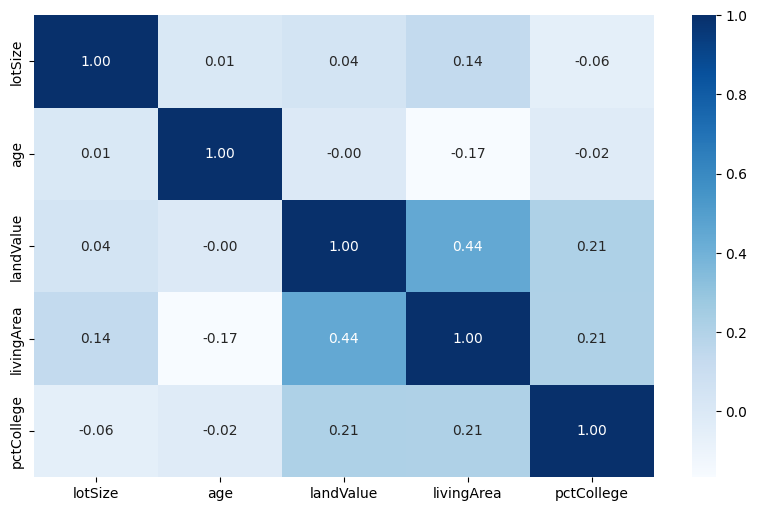

In [20]:
# Creación de la matriz de correlación
features = ['lotSize', 'age', 'landValue', 'livingArea', 'pctCollege']
fig, ax = plt.subplots(figsize=(10,6))
corr = X_train_simplified[features].corr()
sns.heatmap(corr, xticklabels=corr.columns,yticklabels=corr.columns, cmap="Blues", annot=True, fmt=".2f");

La mayoría de las correlaciones fuera de la diagonal principal son bajas, aunque se observa una correlación considerable entre **landValue** y **livingArea**. Si bien esta correlación de 0.44 no es extremadamente alta, no es ideal desde la perspectiva de la regresión lineal, ya que sugiere la presencia de multicolinealidad.

La regularización L1 a menudo presenta dificultades en sus predicciones cuando hay multicolinealidad en los datos, ya que el algoritmo de optimización no se desempeña de manera óptima. Afortunadamente, existe otro tipo de regularización, la **regularización L2**, que es muy eficaz para abordar la multicolinealidad. A continuación, se procederá a aplicar la regularización L2 al conjunto actual de características.

## Aplicando regularización L2 para abordar la multicolinealidad

Un modelo de regresión lineal que utiliza regularización L2 se llama **regresión Ridge**. La regularización L2 añade la magnitud al cuadrado de los coeficientes del modelo de regresión ($\beta_j$) a la función de pérdida de mínimos cuadrados ordinarios (OLS):

$$\sum_{i=1}^N{\big(y_i - \sum_{j=1}^p{x_{ij}\beta_j}}\big)^2 + \color{blue}{\lambda \sum_{j=1}^{p}\beta_j^2} .$$

La regularización L2 también reduce los coeficientes $\beta_j$ hacia cero, sin embargo, los efectos de la reducción suelen ser menores que en la regresión LASSO. Ajustemos el modelo y examinemos los nuevos coeficientes:

In [21]:
# Fitting the model
model_l2 = linear_model.Ridge(alpha=46.2, fit_intercept=True) # higher alpha for stronger regularization
results_l2 = model_l2.fit(X_train_simplified, y_train)

A continuación se muestran los nombres de los coeficientes del modelo seguidos por los valores ajustados de $\beta$. Los coeficientes están ordenados de menor a mayor:

In [22]:
sorted(zip(X_train_simplified.columns, results_l2.coef_), key=lambda x: x[1])

[('newConstruction', -0.009466792154277141),
 ('bedrooms', -0.004526499349889298),
 ('age', -0.003979094915839612),
 ('heating_hot water/steam', -0.003451312943666185),
 ('pctCollege', -0.0005084987354366434),
 ('sewer_public/commercial', 0.00022959222210271416),
 ('sewer_septic', 0.0006730915673457146),
 ('heating_hot air', 0.002213153001592136),
 ('fireplaces', 0.002859991278411815),
 ('fuel_gas', 0.003224238417195966),
 ('centralAir', 0.0036676047793284447),
 ('lotSize', 0.004543383508974203),
 ('rooms', 0.00797587470191808),
 ('waterfront', 0.009482287342842522),
 ('bathrooms', 0.013225543182836672),
 ('landValue', 0.029311102707211694),
 ('livingArea', 0.042448605543419296)]

Aquí, vemos que ```livingArea``` y ```landValue``` tienen los coeficientes más grandes. Esto era de esperar, dado que la exploración original de la visualización de datos de este análisis mostró una relación significativa entre estas variables y los precios de las viviendas.

Sin embargo, es importante preguntarse por qué elegimos usar $\lambda = 46.2$ en este ajuste. El valor de $\lambda$ puede afectar significativamente los coeficientes del modelo, por lo que debe elegirse con cuidado. La siguiente sección explora un método para elegir gráficamente un valor óptimo de $\lambda$.

### Cómo ajustar el parámetro de regularización $\lambda$

Para seleccionar un parámetro $\lambda$ apropiado, utilizaremos el error cuadrático medio (MSE) del modelo aplicado a nuestro conjunto de validación. Recuerda que el MSE del modelo se calcula comparando las predicciones del modelo con los valores verdaderos. Aquí, esto significa comparar los precios de las viviendas predichos por el modelo regularizado con L2 con los precios reales de las viviendas. Valores más bajos del error cuadrático medio indican un mejor rendimiento del modelo.

Vamos a explorar diferentes valores de $\lambda$ y ver los efectos en el rendimiento del modelo. Compararemos el rendimiento en los conjuntos de entrenamiento y validación. Recuerda que valores más altos de $\lambda$ conducen a una regularización más fuerte:

In [23]:
# Loop through different lambda values
lambdas = np.arange(0.1, 100.0, 0.1)

coefs = []
mse_train = []
mse_vali = []
for l in lambdas:
    ridge = linear_model.Ridge(alpha=l, fit_intercept=True)
    ridge.fit(X_train_simplified, y_train)
    mse_train.append(mean_squared_error(y_train, ridge.predict(X_train_simplified))) # train data
    mse_vali.append(mean_squared_error(y_vali, ridge.predict(X_vali_simplified))) # validation data

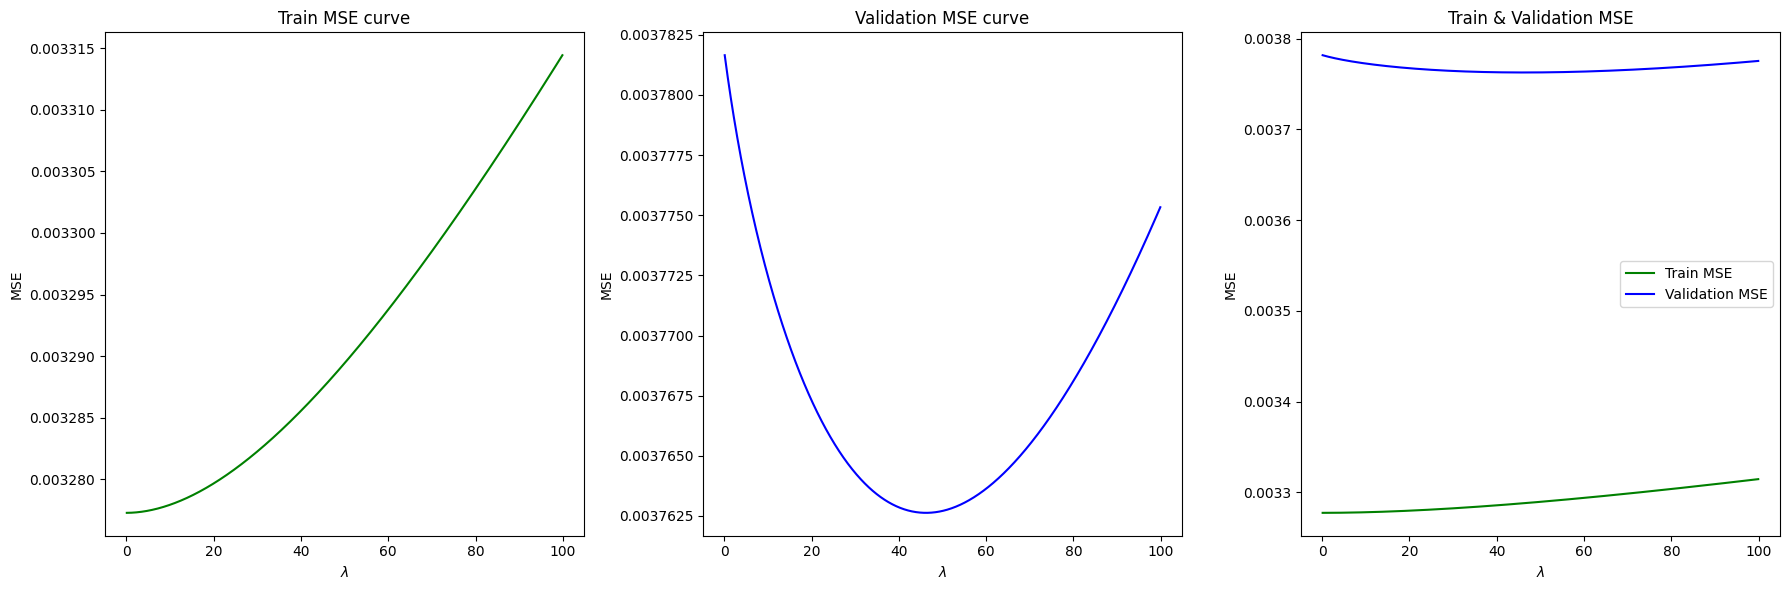

In [24]:
# Plot results
fig, ax1 = plt.subplots(1, 3, figsize=(18, 6))

# Train MSE curve
ax1[0].plot(lambdas, mse_train, 'g-', label='Train MSE')
ax1[0].set_title('Train MSE curve')

# Validation MSE curve
ax1[1].plot(lambdas, mse_vali, 'b-', label='Validation MSE')
ax1[1].set_title('Validation MSE curve')

# Combined plot for both Train and Validation
ax1[2].plot(lambdas, mse_train, 'g-', label='Train MSE')
ax1[2].plot(lambdas, mse_vali, 'b-', label='Validation MSE')
ax1[2].set_title('Train & Validation MSE')
ax1[2].legend()  # Add legend to distinguish the curves

# Set labels for all subplots
for ax in ax1.flat:
    ax.set_xlabel('$\lambda$')
    ax.set_ylabel('MSE')

# Adjust the spacing between subplots to avoid overlap
plt.tight_layout()

# Display the plots
plt.show()


## Método gráfico para la escogencia del lambda

Como determinar la escogencia del $\lambda$ para encontrar un equilibrio entre sobreajuste (overfitting) y subajuste (underfitting) en un modelo de regresión regularizado con L2 (Ridge).

### Sobreajuste con $\lambda$ pequeño

- **Observación en el Modelo**: Cuando $\lambda$ es pequeño, la regularización es débil y el modelo se comporta como una regresión lineal sin penalización adicional. Esto permite que el modelo se ajuste demasiado a los datos de entrenamiento.
- **Evidencia**: El MSE (Mean Squared Error) en el conjunto de validación es mucho mayor que en el conjunto de entrenamiento. Esto indica que el modelo no generaliza bien a datos nuevos y está sobreajustado a los datos de entrenamiento.

### Subajuste con $\lambda$ grande

- **Observación en el Modelo**: Cuando $\lambda$ es grande, la regularización es fuerte, lo que restringe los coeficientes del modelo, haciéndolos más pequeños y, en algunos casos, acercándolos a cero.
- **Evidencia**: El MSE es alto tanto para el conjunto de entrenamiento como para el de validación, lo que indica que el modelo no se ajusta bien a los datos de entrenamiento ni a los datos nuevos. Esto sugiere que el modelo está subajustado.

### Elección del $\lambda$ Óptimo

- **Equilibrio entre Sobreajuste y Subajuste**: El objetivo es encontrar un $\lambda$ que minimice el MSE en el conjunto de validación, lo que indica un buen equilibrio entre la complejidad del modelo y su capacidad de generalización.
- **Método Gráfico**: Al graficar el MSE del conjunto de validación para diferentes valores de $\lambda$, se puede observar dónde se alcanza el mínimo. Este valor de $\lambda$ proporciona el mejor equilibrio entre sobreajuste y subajuste.


Como podemos ver el modelo está sobreajustado, lo que se evidencia por un MSE mucho mayor en el conjunto de validación comparado con el conjunto de entrenamiento, indicando una regresión lineal casi sin regularización. Por otro lado, cuando $\lambda$ es grande, el modelo está subajustado, ya que la fuerte regularización restringe los coeficientes del modelo, resultando en un MSE alto tanto en los datos de entrenamiento como en los de prueba. Para equilibrar el sobreajuste y el subajuste, necesitamos elegir un $\lambda$ óptimo. La curva de MSE del conjunto de validación muestra que el mínimo se alcanza entre 40 y 50, específicamente en $\lambda = 46.1$. Por lo tanto, se recomienda usar un método gráfico para comprender los efectos de la regularización en un modelo de regresión múltiple.


In [ ]:
min_index=mse_vali.index(min(mse_vali))
print("The optimal lambda is: ", lambdas[min_index])
print("Validation MSE=",mse_vali[min_index])
print("Train MSE=", mse_train[min_index])

## Regularización Elastic Net

Ahora que hemos aplicado la regularización L1 y L2 de manera individual, ¿existe un método que nos permita obtener sus beneficios juntos? Afortunadamente, los beneficios de esparsidad de L1 y la robustez y prevención contra el sobreajuste de L2 pueden combinarse en un método llamado **regresión Elastic Net**.

La regularización L1 añade los valores absolutos de los betas a la función objetivo:

$$Loss(Data\ |\ Model) + \color{blue}{\lambda \sum_{j=1}^{p}\big| \beta_j \big|} .$$

Por otro lado, la regularización L2 añade las magnitudes al cuadrado de los betas a la función objetivo:

$$Loss(Data\ |\ Model) + \color{blue}{\lambda \sum_{j=1}^{p}\beta_j^2} .$$

La regresión Elastic Net puede ser un método poderoso para fomentar tanto una solución escasa como una solución que sea robusta contra características perjudiciales como la multicolinealidad. Dado el conjunto de datos $(y_1, ..., y_n)$ y las características observadas para cada $y_i$, es decir, $(x_{i1}, ... ,x_{ip})$, un modelo de regresión con $p$ parámetros $(\beta_0, ..., \beta_p)$ toma la forma,

$$y_i = \sum_{j=1}^{p} x_{ij}\beta_j .$$

La regularización Elastic Net combina las penalizaciones de regularización L1 y L2 para incluir tanto el valor absoluto como la magnitud al cuadrado de los coeficientes beta en la función de pérdida:

$$\sum_{i=1}^{n} (y_i - \sum_{j=1}^{p} x_{ij} \beta_j)^2 + \color{blue}{\alpha \rho \sum_{j=1}^{p}\big| \beta_j \big|} + \color{blue}{\alpha(1-\rho) \sum_{j=1}^{p}\beta_j^2}.$$

Aquí, $\alpha$ es la tasa de regularización, y $\rho$ controla el equilibrio entre la regularización L1 y L2 en la función de pérdida. Es decir, $\rho = 1$ resulta en una penalización L1 pura, $\rho = 0$ resulta en una penalización L2 pura, mientras que $0 < \rho < 1$ resulta en una regularización Elastic Net combinada.

De manera similar a cómo calibramos $\lambda$ en nuestra discusión sobre la regularización L2, es útil construir gráficos en función de la tasa de regularización Elastic Net $\alpha$. Vamos a explorar una lista de diferentes valores de $\alpha$ y graficar los coeficientes en función de $\alpha$:

De manera similar a cómo calibramos $\lambda$ en nuestra discusión sobre la regularización L2, es útil construir gráficos en función de la tasa de regularización Elastic Net $\alpha$. Vamos a explorar una lista de diferentes valores de $\alpha$ y graficar los coeficientes en función de $\alpha$:

In [ ]:
# Loop through different regularization alpha values and record fit coefficients at each value
alpha_list = np.logspace(-5, 1, 50)

coefs = []
for a in alpha_list:
    enet = linear_model.ElasticNet(random_state=0, alpha=a, l1_ratio=0.5, fit_intercept=True)
    enet.fit(X_train_simplified, y_train)
    coefs.append(enet.coef_.ravel())

In [ ]:
# Plot results
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(alpha_list, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim())  # reverse axis
plt.axvline(x=optimal_alpha, color='r', linestyle='--', label='Optimal $\alpha$')
plt.xlabel(r'$\alpha$')
plt.ylabel('Parameter Coefficients')
plt.title(r'Elastic net coefficients as a function of $\alpha$')
plt.axis('tight');

A partir del gráfico anterior, vemos que a medida que $\alpha$ aumenta más allá de ~0.1, todos los coeficientes se vuelven cero. Esto indica que la regularización con un valor de $\alpha$ tan alto es demasiado fuerte. Por otro lado, valores de $\alpha$ muy pequeños llevan a una regularización débil. Podemos ver que a medida que los valores de $\alpha$ disminuyen de derecha a izquierda, las estimaciones de los parámetros comienzan a verse más afectadas cerca de $10^{-4}$. Esto indica que en ese punto la regularización comienza a tener un efecto en el ajuste del modelo.

Ahora que tenemos una idea de cómo los coeficientes se ven afectados por $\alpha$, veamos cómo elegir el valor óptimo de $\alpha$.

### Un método para elegir el $\alpha$ óptimo

Elegir un valor óptimo para $\alpha$ es crucial para el rendimiento del modelo regularizado. Aquí te explico por qué y cómo seleccionar el mejor $\alpha$:

### Importancia de Elegir el $\alpha$ Correcto

1. **$\alpha$ demasiado grande**:
   - **Efecto**: Cuando $\alpha$ es demasiado grande, la regularización es muy fuerte. Esto hace que los coeficientes del modelo se vuelvan muy pequeños o incluso cero, lo que lleva a un modelo demasiado simple.
   - **Consecuencia**: Un modelo demasiado simple no captura adecuadamente las relaciones en los datos, lo que resulta en una baja precisión fuera de muestra (datos de prueba).

2. **$\alpha$ demasiado pequeño**:
   - **Efecto**: Cuando $\alpha$ es demasiado pequeño, la regularización es muy débil. Esto significa que los coeficientes del modelo no se reducen significativamente.
   - **Consecuencia**: La regularización débil no controla el sobreajuste, lo que puede llevar a que el modelo se ajuste demasiado a los datos de entrenamiento y tenga un rendimiento pobre en datos nuevos.

### Método para Seleccionar el $\alpha$ Óptimo

Un enfoque para encontrar el $\alpha$ óptimo es observar cómo varía el R-cuadrado del modelo en función de $\alpha$. El R-cuadrado es una medida de qué tan bien los datos se ajustan al modelo. Buscaremos el $\alpha$ que maximice el R-cuadrado en el conjunto de validación, lo que indica el mejor equilibrio entre ajuste y generalización.

### Procedimiento

1. **Variar $\alpha$**:
   - Ajustar el modelo para diferentes valores de $\alpha$ y calcular el R-cuadrado para cada uno. Este proceso se puede realizar tanto en el conjunto de entrenamiento como en el de validación.

2. **Balance L1 y L2**:
   - En Elastic Net, la proporción entre L1 y L2 regularización se controla con el parámetro `l1_ratio` (denotado como $\rho$). En este análisis, establecemos $\rho$ en 0.5 para equilibrar los efectos de ambas regularizaciones.

3. **Evaluación**:
   - Graficar el R-cuadrado en función de $\alpha$ para visualizar cuál valor proporciona el mejor rendimiento en el conjunto de validación.

### Ejemplo de Código en Python

```python

# Supongamos que tienes X (características) y y (etiquetas) ya definidos
# Dividir los datos en entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Definir un rango de valores de alpha
alpha_range = np.logspace(-4, 1, 50)
train_r2 = []
val_r2 = []

# Iterar sobre los valores de alpha
for alpha in alpha_range:
    model = ElasticNet(alpha=alpha, l1_ratio=0.5, random_state=42)
    model.fit(X_train, y_train)
    
    # Calcular R-cuadrado en conjunto de entrenamiento
    train_pred = model.predict(X_train)
    train_r2.append(r2_score(y_train, train_pred))
    
    # Calcular R-cuadrado en conjunto de validación
    val_pred = model.predict(X_val)
    val_r2.append(r2_score(y_val, val_pred))

# Graficar los R-cuadrado
plt.figure(figsize=(10, 6))
plt.plot(alpha_range, train_r2, label='Train R^2')
plt.plot(alpha_range, val_r2, label='Validation R^2')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('R^2 Score')
plt.title('R^2 vs. Alpha for Elastic Net Regression')
plt.legend()
plt.show()
```



In [ ]:


# Definir un rango de valores de alpha
alpha_range = np.logspace(-5, 1, 50)
train_r2 = []
val_r2 = []

# Iterar sobre los valores de alpha
for alpha in alpha_range:
    model = ElasticNet(alpha=alpha, l1_ratio=0.5, random_state=42)
    model.fit(X_train_simplified, y_train)

    # Calcular R-cuadrado en conjunto de entrenamiento
    train_pred = model.predict(X_train_simplified)
    train_r2.append(r2_score(y_train, train_pred))

    # Calcular R-cuadrado en conjunto de validación
    val_pred = model.predict(X_vali_simplified)
    val_r2.append(r2_score(y_vali, val_pred))

# Graficar los R-cuadrado
plt.figure(figsize=(10, 6))
plt.plot(alpha_range, train_r2, label='Train R^2')
plt.plot(alpha_range, val_r2, label='Validation R^2')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('R^2 Score')
plt.title('R^2 vs. Alpha for Elastic Net Regression')
plt.legend()
plt.show()

# Encontrar el índice del R^2 máximo en el conjunto de validación
optimal_alpha_index = np.argmax(val_r2)
optimal_alpha = alpha_range[optimal_alpha_index]

# Imprimir el alpha óptimo
print(f'El alpha óptimo es: {optimal_alpha}')

### Ejercicio 8:

Escribe un script para cambiar $\rho$ y ver cómo cambia el $\alpha$ óptimo (basado en el máximo R-cuadrado del conjunto de prueba como se vio anteriormente). Específicamente, ¿cuáles son los valores óptimos de $\alpha$ para los siguientes valores de $\rho$: [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]? Comenta sobre lo que sucede cuando $\rho$ es 0 y cuando $\rho$ es 1.

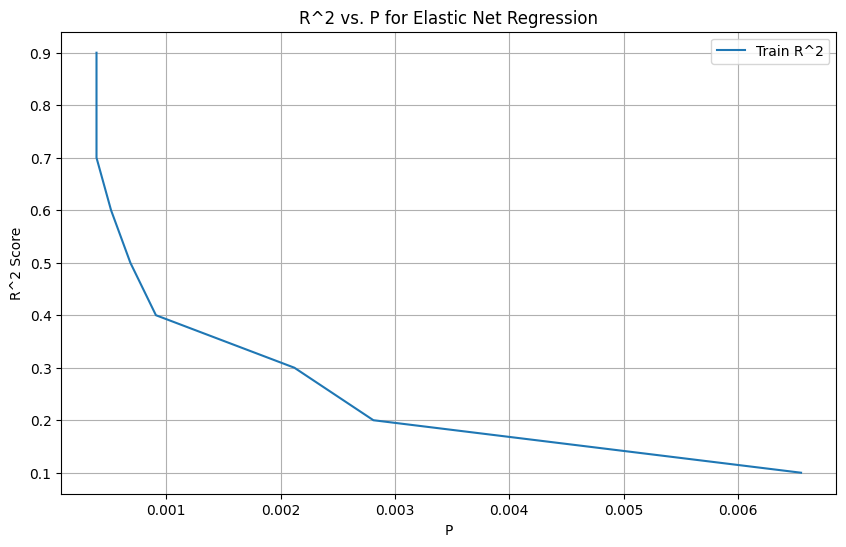

In [27]:
# Definir un rango de valores de alpha
alpha_range = np.logspace(-5, 1, 50)
pethas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
optimal_alpha = []
for petha in pethas:
  # Iterar sobre los valores de alpha
  val_r2 = []
  val_mse = []
  for alpha in alpha_range:
      model = ElasticNet(alpha=alpha, l1_ratio=petha, random_state=42)
      model.fit(X_train_simplified, y_train)
# Calcular R-cuadrado en conjunto de validación
      val_pred = model.predict(X_vali_simplified)
      val_r2.append(r2_score(y_vali, val_pred))
      val_mse.append(mean_squared_error(y_vali, val_pred))

  # Encontrar el índice del R^2 máximo en el conjunto de validación
  optimal_alpha_index = np.argmax(val_r2)
  optimal_alpha.append(alpha_range[optimal_alpha_index])
plt.figure(figsize=(10, 6))
plt.plot(optimal_alpha, pethas, label='Train R^2')
plt.xscale('linear')
plt.xlabel('P')
plt.ylabel('R^2 Score')
plt.title('R^2 vs. P for Elastic Net Regression')
plt.legend()
plt.grid()
plt.show()

### Ejercicio 8:

A partir de todo el estudio anterior, que podría contestar sobre la pregunta  ¿Qué variables destacadas influyen en el precio de las viviendas?

## Conclusiones

En este caso, hemos logrado lo siguiente:

1. Aplicado los fundamentos de la regularización de modelos para la regresión lineal.
2. Aprendido sobre la regularización L1 y cómo LASSO puede ayudar a eliminar parámetros no esenciales. Aunque esta técnica es muy poderosa, es importante no eliminar parámetros sin una justificación adecuada.
3. Comprendido la regularización L2 y su uso para manejar la colinealidad entre los predictores.
4. Aprendido sobre la regularización elastic net, una combinación de las regularizaciones L1 y L2, que ofrece flexibilidad en el tipo de regularización según nuestras necesidades.

Con este conocimiento, puedes utilizar técnicas de regularización para prevenir el sobreajuste en tus modelos y mejorar la precisión de las predicciones. Las predicciones robustas son cruciales no solo para mejorar las estimaciones del modelo, sino también para mantener la confianza en las predicciones del modelo tanto fuera de muestra como en entornos de producción. Las decisiones empresariales basadas en datos dependen de estimaciones precisas, y las técnicas de regularización son herramientas esenciales para lograr ese objetivo.